# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from fast_ml.model_development import train_valid_test_split

In [8]:
def transform_data(train, valid, test, cols):
    labelencoder = LabelEncoder()
    
    for col in train[cols]:
        train[col] = labelencoder.fit_transform(train[col].values)
        valid[col] = labelencoder.transform(valid[col].values)
        test[col] = labelencoder.transform(test[col].values)
        
    for col in train.columns:
        train[col] = train[col].astype('float32')
        valid[col] = valid[col].astype('float32')
        test[col] = test[col].astype('float32')
        
    return train, valid, test


In [9]:
def split_data(features, target):
    x_train, x_test, y_train, y_test = train_test_split(features, target,
    test_size=0.2, random_state = 12345)


    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
    test_size=0.2, random_state= 12345)
    
    return x_train, y_train, x_test, y_test, x_val, y_val

In [10]:
data = pd.read_csv('/datasets/autos.csv')
print(data.shape)
data.head()

(354369, 16)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [11]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Model'], axis=1)
data = data.fillna('unknown')
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,90000,7,gasoline,skoda,no


#### Дополнительно решил удалить Model, тк это лишь название, но бренд решил не трогать. Не стал трогать, потому что в голову залезла мысль, что может быть переплата за бренд. Заменил NaN в Repaired на no, ведь если нет информации, то скорее всего машина не была в ремонте. Данных у нас не мало, поэтому думаю есть смысл просто дропнуть NaN значения в оставшихся колонках, тк восстановить их почти не возможно.

In [12]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [13]:
data.shape

(354369, 10)

In [14]:
data = data.dropna()
data.shape

(354369, 10)

In [15]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Kilometer          354369 non-null  int64 
 6   RegistrationMonth  354369 non-null  int64 
 7   FuelType           354369 non-null  object
 8   Brand              354369 non-null  object
 9   Repaired           354369 non-null  object
dtypes: int64(5), object(5)
memory usage: 29.7+ MB


In [17]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


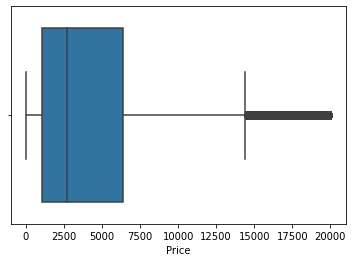

In [18]:
sns.boxplot(data.Price)
plt.show()

#### Цена у нас в диапозоне от 1000 до 7000. Оставлю от 100 до 14000.

In [19]:
data = data[(data['Price'] >= 1000) & (data['Price'] <= 14000)]

#### Год регистрации 1910. Аномалия. Мощность = 0. Аномалия. Месяц регистрации = 0. Аномалия, тк от 0 до 12 включительно будет 13 месяцев, а это не возможно, так что скорее всего это аномалия.

In [23]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,90000,7,gasoline,skoda,no
6,2200,convertible,2004,manual,109,150000,8,petrol,peugeot,no
10,2000,sedan,2004,manual,105,150000,12,petrol,mazda,no


In [24]:
data = data[data['RegistrationYear'] >= 1970]

data = data[data['Power'] >= 30]

#### 'RegistrationMonth идет от 0 до 12 (в сумме 13 чисел), а это возможно лишь в том случае, если 0 отвечает за то, что нет данных по месяцу, мол человек не помнил и поставил 0

In [25]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,90000,7,gasoline,skoda,no
6,2200,convertible,2004,manual,109,150000,8,petrol,peugeot,no
10,2000,sedan,2004,manual,105,150000,12,petrol,mazda,no


In [26]:
data = data.reset_index(drop=True)

#### С аномалиями и выбросами покончено.

In [27]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,9800,suv,2004,auto,163,125000,8,gasoline,jeep,unknown
1,1500,small,2001,manual,75,150000,6,petrol,volkswagen,no
2,3600,small,2008,manual,69,90000,7,gasoline,skoda,no
3,2200,convertible,2004,manual,109,150000,8,petrol,peugeot,no
4,2000,sedan,2004,manual,105,150000,12,petrol,mazda,no


#### Метод info() показал, что у нас в строках может использоваться тип str, а этого допустить ну уж никак нельзя, поэтому поменяем в ручную тип данных на float32:

In [28]:
data.shape

(229914, 10)

## Обучение моделей

In [29]:
x_train, y_train, x_test, y_test, x_valid, y_valid = split_data(data.iloc[:,1:], data['Price'])

#### Перейдем к кодировке:

#### Чтобы не дублировать код напишем функцию transform_data и применим её к x_train, x_valid, x_test

In [36]:
x_train, x_valid, x_test = transform_data(x_train, x_valid, x_test, ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired'])

In [37]:
parameters_grid_rfr = {
    'n_estimators': range(60, 120, 10),
    'min_samples_split': range(2, 4,1),
    'random_state': [12345]
}

In [38]:
rfr = RandomForestRegressor()

In [39]:
%%time

rfr_grid_cv = GridSearchCV(rfr, parameters_grid_rfr, scoring = 'neg_root_mean_squared_error', cv = 3, n_jobs=-1)

rfr_grid_cv.fit(x_train, y_train)

print(f'Наилучшая точность: {(-1)*round(rfr_grid_cv.best_score_, 3)}')
print(f'Наилучшая модель: {rfr_grid_cv.best_estimator_}') 
print(f'Наилучшие параметры: {rfr_grid_cv.best_params_}') 

Наилучшая точность: 1463.11
Наилучшая модель: RandomForestRegressor(min_samples_split=3, n_estimators=110, random_state=12345)
Наилучшие параметры: {'min_samples_split': 3, 'n_estimators': 110, 'random_state': 12345}
CPU times: user 11min 55s, sys: 12.1 s, total: 12min 7s
Wall time: 12min 8s


#### 6 min and 31 sec. Для обучения это не такая уж и великая цифра, да и качество приемлемое, однако стоит заметить, что и гиперпараметров было не столь много. Посмотрим как быстро и насколько успешно lgmb справиться с задачей обучения.

In [40]:
parameters_grid_lgbm = {
    'n_estimators': range(80, 120, 10),
    'boosting_type': ['gbdt', 'dart'],
    'random_state': [12345]
}

In [41]:
lgbm = LGBMRegressor()

In [42]:
%%time

lgbm_grid_cv = GridSearchCV(lgbm, parameters_grid_lgbm, scoring = 'neg_root_mean_squared_error', cv = 3, n_jobs=-1)

lgbm_grid_cv.fit(x_train, y_train)

print(f'Наилучшая точность: {(-1)*round(lgbm_grid_cv.best_score_, 3)}')
print(f'Наилучшая модель: {lgbm_grid_cv.best_estimator_}') 
print(f'Наилучшие параметры: {lgbm_grid_cv.best_params_}') 

Наилучшая точность: 1484.347
Наилучшая модель: LGBMRegressor(n_estimators=110, random_state=12345)
Наилучшие параметры: {'boosting_type': 'gbdt', 'n_estimators': 110, 'random_state': 12345}
CPU times: user 7min 1s, sys: 1.72 s, total: 7min 3s
Wall time: 7min 6s


#### Выведем точность и время предсказания для модели rfr:

In [43]:
%%time
mean_squared_error(y_valid, rfr_grid_cv.best_estimator_.predict(x_valid))**(1/2)

CPU times: user 1.53 s, sys: 4.52 ms, total: 1.53 s
Wall time: 1.59 s


1414.0540172594363

#### В целом 1 секунда это не плохой результат. Посмотрим, что скажет lgmb.

#### Выведем точность и время предсказания для модели lgmb:

In [46]:
%%time

mean_squared_error(y_valid, lgbm_grid_cv.best_estimator_.predict(x_valid))**(1/2)

CPU times: user 319 ms, sys: 0 ns, total: 319 ms
Wall time: 242 ms


1475.6611336689461

## Анализ моделей

### Вывод: за основу возьмем валидационный набор. ~0.3 sec. для lgmb  не может не радовать, ведь по-моему мнению это не так много. Время предсказания для lgbm примерно в 3,4 раза быстрее. В этом пункте финалист явно lgbm. Разница же в точности составляет 6 единиц, много это или мало, по-хорошему, должен сказать заказчик. Я считаю, что это не большая разница. Однако время, которое уходит на ответ в 3,4 раза меньше, а это уже показатель. Единственный минус для lgmb в том, что обучается она в 2 раза дольше, а если задачу увеличить, то и время обучения, скорее всего, будет расти по экспоненте. Исходя из вышеуказанного, я считаю, что можно сделать вывод о превосходстве lgbm над rfr в данной задаче. В других же работах, думаю, стоит тщательно обдумать какой метод именно выбирать, ведь lgbm быстро предсказывает, но долго обучается, а rfr наоборот - быстро обучается (в рамках нашей задачи) и дольше предсказывает. Короче говоря всё относительно и нужно отталкиваться от условий конкретной задачи.

##### Так же проверим на тестовой выборке корректность модели (проверим, что модель не переобучилась)

In [45]:
%%time

mean_squared_error(y_test, lgbm_grid_cv.best_estimator_.predict(x_test))**(1/2)

CPU times: user 377 ms, sys: 0 ns, total: 377 ms
Wall time: 325 ms


1490.6900756252992

#### Модель не переобучилась и работает корректно